# Практическое задание к уроку 5. Детектирование объектов

Обучить детектор объектов с помощью TensorFlow Object Detection API

Библиотеки: [Python, Tensorflow]

Ноутбук выполнен на основании туториала: https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/auto_examples/plot_object_detection_saved_model.html#sphx-glr-auto-examples-plot-object-detection-saved-model-py


## Загрузка тестовых изображений

Источник `TensorFlow Model Garden <https://github.com/tensorflow/models/tree/master/research/object_detection/test_images>`

In [1]:
%matplotlib inline

In [2]:
!pip install tensorflow-object-detection-api

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Подавление протоколирования тензорного потока (1)
import pathlib
import tensorflow as tf

tf.get_logger().setLevel('ERROR')           # Подавление протоколирования тензорного потока (2)

# Включение динамического выделение памяти графического процессора
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

def download_images():
    base_url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/test_images/'
    filenames = ['/content/10.jpeg', '/content/11.jpeg', '/content/12.jpeg', '/content/13.jpeg', '/content/14.jpeg', '/content/15.jpeg', '/content/16.jpeg']
    image_paths = []
    for filename in filenames:
        image_path = tf.keras.utils.get_file(fname=filename,
                                            origin=base_url + filename,
                                            untar=False)
        image_path = pathlib.Path(image_path)
        image_paths.append(str(image_path))
    return image_paths

IMAGE_PATHS = download_images()

## Загрузка модели

The particular detection algorithm we will use is the
`CenterNet HourGlass104 1024x1024`. More models can be found in the `TensorFlow 2 Detection Model Zoo <https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md>`_.
To use a different model you will need the URL name of the specific model. This can be done as
follows:

1. Right click on the `Model name` of the model you would like to use;
2. Click on `Copy link address` to copy the download link of the model;
3. Paste the link in a text editor of your choice. You should observe a link similar to ``download.tensorflow.org/models/object_detection/tf2/YYYYYYYY/XXXXXXXXX.tar.gz``;
4. Copy the ``XXXXXXXXX`` part of the link and use it to replace the value of the ``MODEL_NAME`` variable in the code shown below;
5. Copy the ``YYYYYYYY`` part of the link and use it to replace the value of the ``MODEL_DATE`` variable in the code shown below.

For example, the download link for the model used below is: ``download.tensorflow.org/models/object_detection/tf2/20200711/centernet_hg104_1024x1024_coco17_tpu-32.tar.gz``



In [4]:
# Загрузка и извлечение модели
def download_model(model_name, model_date):
    base_url = 'http://download.tensorflow.org/models/object_detection/tf2/'
    model_file = model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(fname=model_name,
                                        origin=base_url + model_date + '/' + model_file,
                                        untar=True)
    return str(model_dir)

MODEL_DATE = '20200711'
MODEL_NAME = 'centernet_hg104_1024x1024_coco17_tpu-32'
PATH_TO_MODEL_DIR = download_model(MODEL_NAME, MODEL_DATE)

## Загрузка ярлыков

Поскольку предварительно обученная
модель, которую мы будем использовать, была обучена на наборе данных COCO, нужно загрузить файл``mscoco_label_map.pbtxt``, соответствующий этому набору данных.

Полный список файлов ярлыков TensorFlow можно найти здесь <https://github.com/tensorflow/models/tree/master/research/object_detection/data>.



In [5]:
# Download labels file
def download_labels(filename):
    base_url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/'
    label_dir = tf.keras.utils.get_file(fname=filename,
                                        origin=base_url + filename,
                                        untar=False)
    label_dir = pathlib.Path(label_dir)
    return str(label_dir)

LABEL_FILENAME = 'mscoco_label_map.pbtxt'
PATH_TO_LABELS = download_labels(LABEL_FILENAME)

## Загрузка сохраненной модели и создание функции обнаружения

In [6]:
import time
import io
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"

print('Loading model...', end='')
start_time = time.time()

# Загрузка сохраненной модели и создание функции обнаружения
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 50.70500612258911 seconds


## Загрузка данных карты ярлыков (для построения графика)


In [7]:
import tensorflow.compat.v1 as tf
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

## Сборка всего воедино

Изображение загружается, прогоняется через модель обнаружения, результат обнаружения и ключевые точки визуализируются.

При первом запуске кода процесс занимает много времени (несполько минут) из
-за компиляции трассировки tf.function --- при последующих запусках (например, на новых изображениях) все будет
быстрее.

Выполнение вывода для /content/10.jpeg... Done
Выполнение вывода для /content/11.jpeg... Done
Выполнение вывода для /content/12.jpeg... Done
Выполнение вывода для /content/13.jpeg... Done
Выполнение вывода для /content/14.jpeg... Done
Выполнение вывода для /content/15.jpeg... Done
Выполнение вывода для /content/16.jpeg... Done


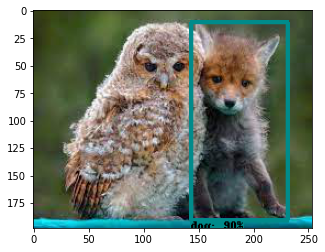

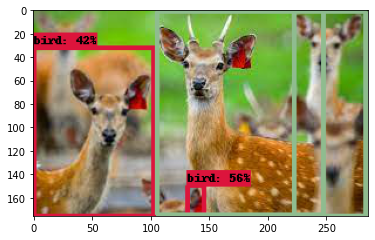

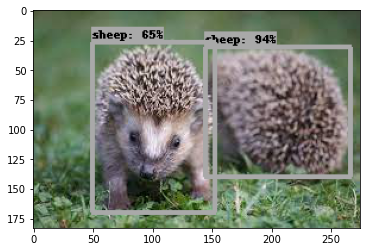

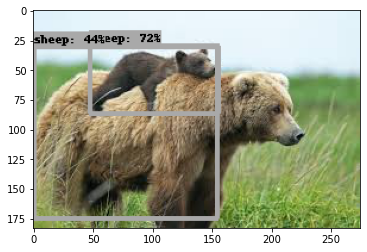

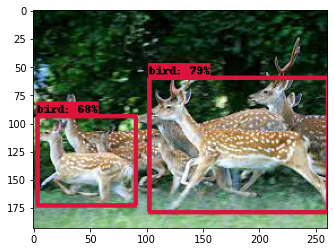

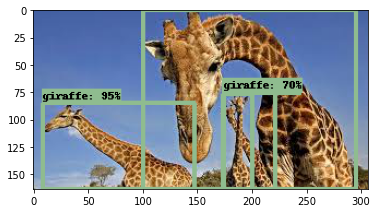

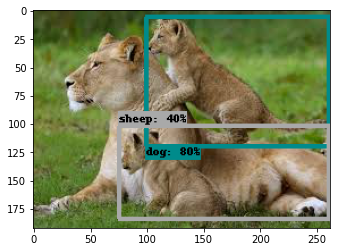

In [8]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
# warnings.filterwarnings('ignore')   # Игнорирует предупреждения Matplotlib

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))


for image_path in IMAGE_PATHS:

    print('Выполнение вывода для {}... '.format(image_path), end='')

    image_np = load_image_into_numpy_array(image_path)

    # Можно попробовать:
    # Перевернуть горизонтально
    # image_np = np.fliplr(image_np).copy()

    # Преобразовать изображения в оттенки серого
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    # Входные данные должны быть тензором. Преобразование с помощью `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # Модель ожидает пакет изображений, поэтому добавляется ось с помощью `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)

    # Все выходные данные являются тензорами пакетов.
    # Преобразуйте в массивы numpy и возьмите индекс [0], чтобы удалить пакетное измерение.
    # Нас интересуют только первые num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes должны быть целыми числами.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False)

    plt.figure()
    plt.imshow(image_np_with_detections)
    print('Done')
plt.show()

# sphinx_gallery_thumbnail_number = 2